In [1]:
from __future__ import division, print_function
import numpy as np
from trial import Trial
from trialCont import TrialCont

from dataPoint import DataPoint
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from continuousPomdp import ContinuousPOMDP
from pomdpWithCost import POMDPWithCost
from pomdpReactionSz import POMDPReactionSz
#from fit import Fit
from analysis import Analysis
from environment import Environment
from pomdpReactionSeqSz import POMDPReactionSeqSz
import copy

%matplotlib inline

# General Parameters

In [2]:
num_samples = 10000
std_z = 1.0
num_quantiles = 10
step_time = 10.0
mu_i = 0.0
k = 1

# Parameters of visualization

In [3]:
font = {'weight' : 'normal',
        'size'   : 36}
font2 = {'weight' : 'normal',
        'size'   : 27}
font3 = {'weight' : 'normal',
        'size'   : 32}
colors = ['red', 'blue', 'black', 'green', 'saddlebrown', 'indigo', 'm']

def setPlot():
    matplotlib.rc('font', **font)
    axes = plt.gca()
    figure = plt.gcf()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.tick_params(top = u'off', right = u'off')
    axes.tick_params(direction='out', width = '2')
    figure.set_size_inches(8,8)
    plt.xlabel("Stimulus duration (ms)")
    plt.xlim([50, 700])

# Functions for visualization based on coherence and time

In [4]:
def analysisCoherence(a_r, ax, ax2, _color = 'blue', _label = 'Accuracy', _fmt = '-o', error = True, _edge_color = None):
    if _edge_color == None:
        _edge_color = _color
    cohs = np.array(sorted(a_r.keys()))
    all_acc = np.zeros(len(cohs))
    err_acc = np.zeros(len(cohs))
    for c, a_r_list in a_r.items():
        i = np.where(cohs == c)[0][0]
        num_trials = 0
        for a_r_point in a_r_list:
            num_trials += a_r_point.nrData
            err_acc[i] += a_r_point.performance *(1-a_r_point.performance)
            all_acc[i] += a_r_point.nrData * a_r_point.performance
        if num_trials > 0:
            err_acc[i] = err_acc[i] / float(num_trials)
            all_acc[i] = all_acc[i] / float(num_trials)
            
    cohs2 = np.array(sorted(a_r.keys()))
    cohs2 = cohs2[np.where(all_acc > 0)[0]]
    err_acc = err_acc[np.where (all_acc > 0)[0]]
    all_acc = all_acc[np.where (all_acc > 0)[0]]
    err_acc = err_acc ** .5
    if cohs2[0] == 0:
        cohs2[0] = 4    
    if error:
        ax.errorbar(cohs2, all_acc, fmt = _fmt, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
        ax2.errorbar(cohs2, all_acc, fmt = _fmt, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    else:
        ax.plot(cohs2, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
        ax2.plot(cohs2, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    
    ax.set_xscale('log')
    ax.minorticks_off()
    ax2.set_xscale('log')
    ax2.minorticks_off()

    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(labelleft='off')  
    ax.tick_params(top = u'off', right = u'off')
    ax2.tick_params(top = u'off', right = u'off', left = u'off')
    ax.tick_params(direction='out', width = '2')
    ax2.tick_params(direction='out', width = '2')

    ax.set_xticks([4])
    ax.set_xticklabels([0])

    ax.set_xlim([3, 7])
    ax2.set_xlim([8, 700])

    ax2.set_xticks([16, 64, 512])
    ax2.set_xticklabels([1.6, 6.4, 51.2])
    f.set_size_inches(8,8)
    d = .025  
    ratio = 6
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-ratio*.5*d, 1+ratio*.5*d), (-d, +d), **kwargs)        # top-left diagonal
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-.5*d, +.5*d), (- d, + d), **kwargs)  # bottom-left diagonal
    f.subplots_adjust(wspace=.07) 
    
    plt.xlabel("Motion strength (%coh)")    
    return  

def analysisDurCoherence(a_r, ax, ax2, add_time = 0, _color = 'blue', _label = 'Accuracy', _fmt = '-o', _edge_color = None, error = False):
    if _edge_color == None:
        _edge_color = _color
    cohs = np.array(sorted(a_r.keys()))
    all_acc = np.zeros(len(cohs))
    err_acc = np.zeros(len(cohs))
    for c, a_r_list in a_r.items():
        i = np.where(cohs == c)[0][0]
        num_trials = 0
        all_dur = []
        weights = []
        
        for a_r_point in a_r_list:
            weights.append(a_r_point.nrData)
            all_dur.append(a_r_point.avg_duration)
            num_trials += a_r_point.nrData
            all_acc[i] += a_r_point.nrData * (a_r_point.avg_duration + add_time)
            
        average = np.average(all_dur, weights=weights)
        variance = np.average((all_dur-average)**2, weights=weights)       
        if num_trials > 0:
            all_acc[i] = all_acc[i] / float(num_trials)
        err_acc[i] = (variance / len(all_dur))**.5 
    
    cohs2 = np.array(sorted(a_r.keys()))
    cohs2 = cohs2[np.where(all_acc > 0)[0]]
    all_acc = all_acc[np.where (all_acc > 0)[0]]
    if cohs2[0] == 0:
        cohs2[0] = 4    
    
    if error:
        ax.errorbar(cohs2, all_acc, fmt = _fmt, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
        ax2.errorbar(cohs2, all_acc, fmt = _fmt, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    else:
        ax.plot(cohs2, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
        ax2.plot(cohs2, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    
    ax.set_xscale('log')
    ax.minorticks_off()
    ax2.set_xscale('log')
    ax2.minorticks_off()

    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(labelleft='off')  
    ax.tick_params(top = u'off', right = u'off')
    ax2.tick_params(top = u'off', right = u'off', left = u'off')
    ax.tick_params(direction='out', width = '2')
    ax2.tick_params(direction='out', width = '2')

    ax.set_xticks([4])
    ax.set_xticklabels([0])

    ax.set_xlim([3, 7])
    ax2.set_xlim([8, 700])

    ax2.set_xticks([16, 64, 512])
    ax2.set_xticklabels([1.6, 6.4, 51.2])
    f.set_size_inches(8,8)
    d = .025  
    ratio = 6
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-ratio*.5*d, 1+ratio*.5*d), (-d, +d), **kwargs)        # top-left diagonal
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-.5*d, +.5*d), (- d, + d), **kwargs)  # bottom-left diagonal
    f.subplots_adjust(wspace=.07) 
    
    plt.xlabel("Motion strength (%coh)")    
    return  

def analysisTime(a_r, _color = 'blue', _label = ['Accuracy'], _fmt = '-', error = True, _edge_color = None):
    if _edge_color == None:
        _edge_color = _color
    cohs = np.array(list(a_r.keys()))
    all_acc = np.zeros(num_quantiles)
    err_acc = np.zeros(num_quantiles)
    num_trials = np.zeros(num_quantiles)
    dur = np.zeros(num_quantiles)
    for c in cohs:
        t = 0
        for a_r_point in a_r[c]:
            num_trials[t] += a_r_point.nrData
            err_acc[t] += a_r_point.performance * (1-a_r_point.performance)
            all_acc[t] += a_r_point.nrData * a_r_point.performance
            dur[t] = a_r_point.avg_duration
            t = t + 1

    # remove 0 number trials (may happen in reaction time task)
    all_acc = all_acc[np.where(num_trials > 0)[0]]
    err_acc = err_acc[np.where(num_trials > 0)[0]]
    dur = dur[np.where(num_trials > 0)[0]]
    num_trials = num_trials[np.where(num_trials > 0)[0]]
    # normilize:
    all_acc = all_acc / num_trials
    err_acc = err_acc / num_trials
    err_acc = err_acc ** .5
    setPlot()
    
    if error:  
        plt.errorbar(dur, all_acc, fmt = _fmt, xerr = 0, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor = _edge_color, markersize = 10, markeredgewidth = 3)
    else:
        plt.plot(dur, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    
    plt.gca().set_xticks([100, 300, 500, 700])
    return 

# Load Data

In [5]:
trials = TrialCont.readFile('beh_data.S6.mat')
time_windows = Trial.sortAndDivideToQuantiles(trials, num_quantiles) 
#trials_sep_sure = Trial.seperateBySureShown(trials)
trials_acc = Trial.seperateByCoherence(trials)
cohs = np.array(sorted(trials_acc.keys()))
analysis = Analysis(time_windows)

# Roitman and Shadlen data

In [6]:
num_samples = 20000
std_i = 20
std_z  = 3.7
step_time = 25
mu_i = 0


num_quantiles = 10
#trials = Trial.readFileRt('b_rt') 
#time_windows = Trial.sortAndDivideToQuantiles(trials, num_quantiles) 
#trials_sep_sure = Trial.seperateBySureShown(trials)
#trials_acc = Trial.seperateByCoherence(trials_sep_sure[False])
#analysis = Analysis(time_windows)
#cohs = np.array(sorted(trials_acc.keys()))
num_trials = len(trials)
sac_time = trials[int(len(trials)/100)].duration

all_reps = []
for trial in trials:
    all_reps.append(trial.conf_rep)
sorted_reps = np.array(sorted(all_reps))
print (sorted_reps[29], sorted_reps[-30] )


acc_r = {}
for c in cohs:
    acc_r[c] = DataPoint.pointsFromTrialsQuantiles(trials_acc[c], time_windows, False)
    
k = 1.7
cost = .003
rcpc = POMDPReaction(k, mu_i, std_i, cohs, cost, 20000, std_z, step_time, num_samples)
fake_trials = rcpc.generateTrials()
time_windows_f = Trial.sortAndDivideToQuantiles(fake_trials, num_quantiles) 
trials_sep_sure_f = Trial.seperateBySureShown(fake_trials)
trials_acc_f = Trial.seperateByCoherence(trials_sep_sure_f[False])
acc_f = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'Accuracy')


-5.651508949468695 4.260173608559018


NameError: name 'POMDPReaction' is not defined

In [7]:
confidence_results_r = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'Confidence')

NameError: name 'rcpc' is not defined

In [8]:
def accDurCoh (acc_r, sac_time = 0):
    cohs = np.array(sorted(trials_acc.keys()))
    all_acc = np.zeros(len(cohs))
    all_dur = np.zeros(len(cohs))
    nt = np.zeros(len(cohs))
    for c, a_r_list in acc_r.items():
        i = np.where(cohs == c)[0][0]
        num_trials = 0
        for a_r_point in a_r_list:
            num_trials += a_r_point.nrData
            all_acc[i] += a_r_point.nrData * a_r_point.performance
            all_dur[i] += a_r_point.nrData * (a_r_point.avg_duration + sac_time) 
        if num_trials > 0:
            all_acc[i] = all_acc[i] / float(num_trials)
            all_dur[i] = all_dur[i] / float(num_trials)
        nt[i] = num_trials
    return all_acc, all_dur / 1000.0, nt

In [9]:
a, d, nt = accDurCoh(acc_r)
af, df, ntf = accDurCoh(acc_f, sac_time)

NameError: name 'acc_f' is not defined

/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 1000)

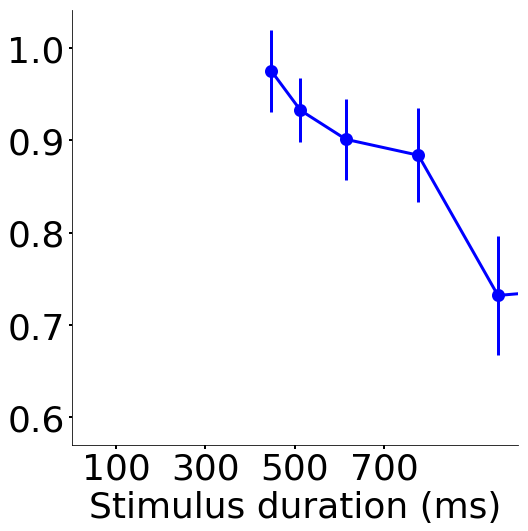

In [10]:
plt.figure()
setPlot()
analysisTime(acc_r, _fmt = '-', _color = 'blue', error = False)
analysisTime(acc_r, _fmt = 'o', _color = 'blue', error = True)
plt.xlim([0,1000])

NameError: name 'acc_f' is not defined

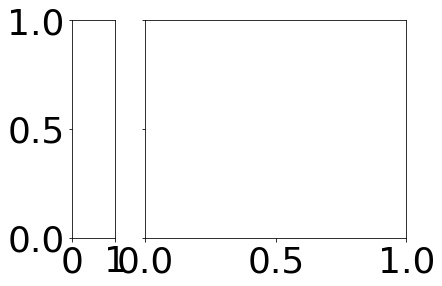

In [11]:
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_f, ax, ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(acc_r, ax, ax2, _fmt = 'o', _color = 'blue', error = True)

plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results_r, ax, ax2, _fmt = '--', _color = 'green')

plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
#analysisDurCoherence(acc_r, ax, ax2, add_time = 0,  _fmt = '-', _color = 'blue')
analysisDurCoherence(acc_f, ax, ax2, add_time = sac_time,  _fmt = '-', _color = 'red')
analysisDurCoherence(acc_r, ax, ax2, add_time = 0,  _fmt = 'o-', _color = 'blue', error = True)


ax.set_ylabel("Reaction Time")
plt.show()

In [12]:
min_conf = 1
max_conf = 0
min_sac = +100
max_sac = -100

for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(confidence_results_r[c])
    for point in acc_r[c]:
        if point.conf_rep < min_sac:
            min_sac = point.conf_rep
        if point.conf_rep > max_sac:
            max_sac = point.conf_rep
    min_c_conf = np.min(prob)
    max_c_conf = np.max(prob)
    if min_c_conf < min_conf:
        min_conf = min_c_conf
    if max_c_conf > max_conf:
        max_conf = max_c_conf


NameError: name 'confidence_results_r' is not defined

[  0  32  64 128 256 512]


/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


NameError: name 'confidence_results_r' is not defined

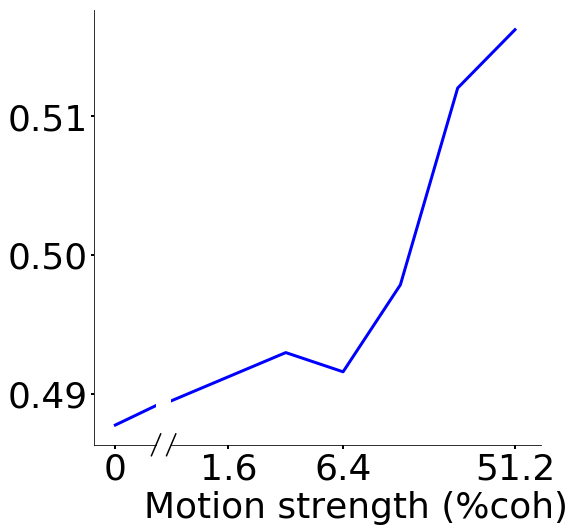

In [13]:
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
#analysisCoherence(confidence_results_r, ax, ax2, _fmt = '--', _color = 'green')
all_points = np.zeros(len(cohs))
for c, a_r_list in acc_r.items():
    #print (c, cohs)
    i = np.where(cohs == c)[0][0]
    num_trials = 0
    for a_r_point in a_r_list:
        num_trials += a_r_point.nrData
        all_points[i] += a_r_point.nrData * a_r_point.conf_rep
    if num_trials > 0:
        all_points[i] = all_points[i] / float(num_trials)

all_points = (max_conf - min_conf) * (all_points - min_sac) / (max_sac - min_sac) + min_conf
cohs2 = copy.copy(cohs)
print (cohs2)
if cohs2[0] == 0:
    cohs2[0] = 4    
    ax.plot(cohs2, all_points, color = 'blue', linewidth = 3, markersize = 10, markeredgewidth = 3)
    ax2.plot(cohs2, all_points, color = 'blue', linewidth = 3, markersize = 10, markeredgewidth = 3)
    
ax.set_xscale('log')
ax.minorticks_off()
ax2.set_xscale('log')
ax2.minorticks_off()
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(labelleft='off')  
ax.tick_params(top = u'off', right = u'off')
ax2.tick_params(top = u'off', right = u'off', left = u'off')
ax.tick_params(direction='out', width = '2')
ax2.tick_params(direction='out', width = '2')

ax.set_xticks([4])
ax.set_xticklabels([0])

ax.set_xlim([3, 7])
ax2.set_xlim([8, 700])

ax2.set_xticks([16, 64, 512])
ax2.set_xticklabels([1.6, 6.4, 51.2])
f.set_size_inches(8,8)
d = .025  
ratio = 6
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-ratio*.5*d, 1+ratio*.5*d), (-d, +d), **kwargs)        # top-left diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-.5*d, +.5*d), (- d, + d), **kwargs)  # bottom-left diagonal
f.subplots_adjust(wspace=.07) 

plt.xlabel("Motion strength (%coh)")    
analysisCoherence(confidence_results_r, ax, ax2, _fmt = '--', _color = 'green')


# Reaction Time (Figure 7b, c, d)

In [14]:
trials = Trial.readFile('beh_data.monkey1.mat')
time_windows = Trial.sortAndDivideToQuantiles(trials, num_quantiles) 
trials_sep_sure = Trial.seperateBySureShown(trials)
trials_acc = Trial.seperateByCoherence(trials_sep_sure[False])
trials_sure = Trial.seperateByCoherence(trials_sep_sure[True])
trials_sure_reject = Trial.seperateByCoherence(Trial.seperateBySureChosen(trials_sep_sure[True])[False])
cohs = sorted(trials_acc.keys())
analysis = Analysis(time_windows)

In [15]:
num_samples = 5000
cost =  2 * 10 ** -3
gamma = 1.
k = 1
std_i = 5
std_z  = .75
step_time = 10
sz = .4

Report toegther 

In [16]:
rcpc = POMDPReactionSz(k, mu_i, sz, std_i, cohs, cost, 20000, std_z, step_time, num_samples)
fake_trials = rcpc.generateTrials()
time_windows_f = Trial.sortAndDivideToQuantiles(fake_trials, num_quantiles) 
trials_sep_sure_f = Trial.seperateBySureShown(fake_trials)
trials_acc_f = Trial.seperateByCoherence(trials_sep_sure_f[False])
analysis = Analysis(time_windows_f)
acc_results_r = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'Accuracy')
confidence_results_r = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'Confidence')
confidence_results_r_correct = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'ConfidenceCorrect')
confidence_results_r_error = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs[:-1], 'ConfidenceIncorrect')

In [17]:
cohs

[0, 16, 32, 64, 128, 256, 512]

/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


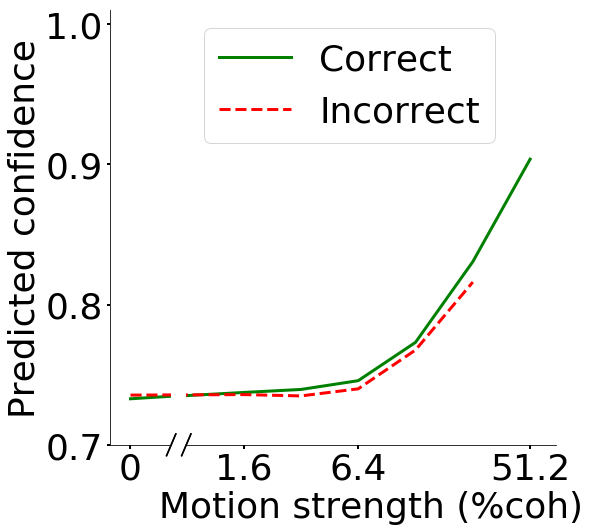

In [18]:
#confidence_results_r_error.pop(256)
#confidence_results_r_error.pop(0)
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results_r_correct, ax, ax2, _fmt = '-', _color = 'green', error = False)
#analysisCoherence(confidence_results_r_correct, ax, ax2, _fmt = 'o', _color = 'blue', error = True)
analysisCoherence(confidence_results_r_error, ax, ax2, _fmt = '--', _color = 'red', error = False)
#analysisCoherence(confidence_results_r_error, ax, ax2, _fmt = 'o', _color = 'red', error = True)

ax.set_ylabel("Predicted confidence")

ax.set_ylim([.7, 1.01])
ax.set_yticks([.70, .80, .90, 1.0])
custom_lines = [matplotlib.lines.Line2D([0], [0], color='green', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3, ls = '--')]
plt.legend(custom_lines, ['Correct', 'Incorrect'],loc = 2)
plt.savefig('paper_figures/confidence_reaction_correct_error_coh.png' , format='png', dpi=100, bbox_inches= "tight")


/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


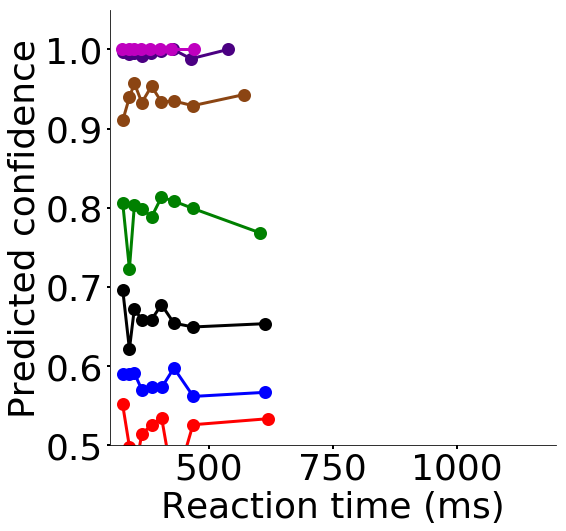

In [19]:
#figure 7d
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(acc_results_r[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]  
    plt.plot(dur + 300, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   
#plt.legend(np.array(cohs)/10, bbox_to_anchor =(1, 1))
setPlot()
plt.ylabel("Predicted confidence")
plt.ylim([.5,1.05])
plt.xlim([300,1200])
plt.xlabel("Reaction time (ms)")
plt.title("")
plt.savefig('paper_figures/confidence_reaction_seq.png' , format='png', dpi=100)
        

/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'')

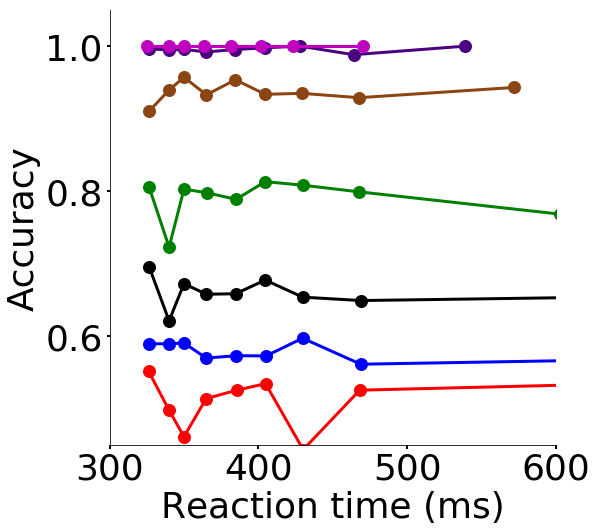

In [20]:
#figure 7d
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(acc_results_r[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]  
    plt.plot(dur + 300, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   
#plt.legend(np.array(cohs)/10, bbox_to_anchor =(1, 1))
setPlot()
plt.ylabel("Accuracy")
plt.ylim([.45,1.05])
plt.xlim([300,600])
plt.xlabel("Reaction time (ms)")
plt.title("")

/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


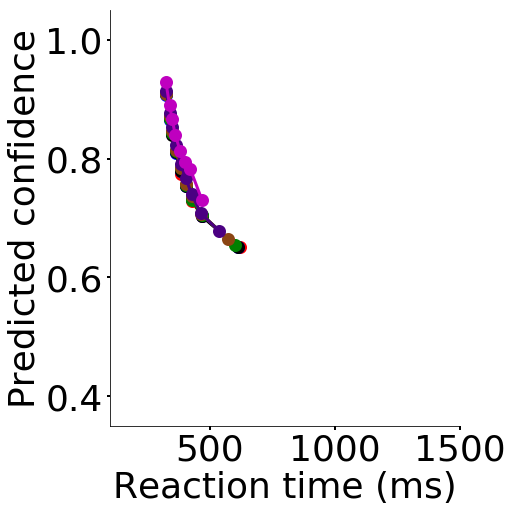

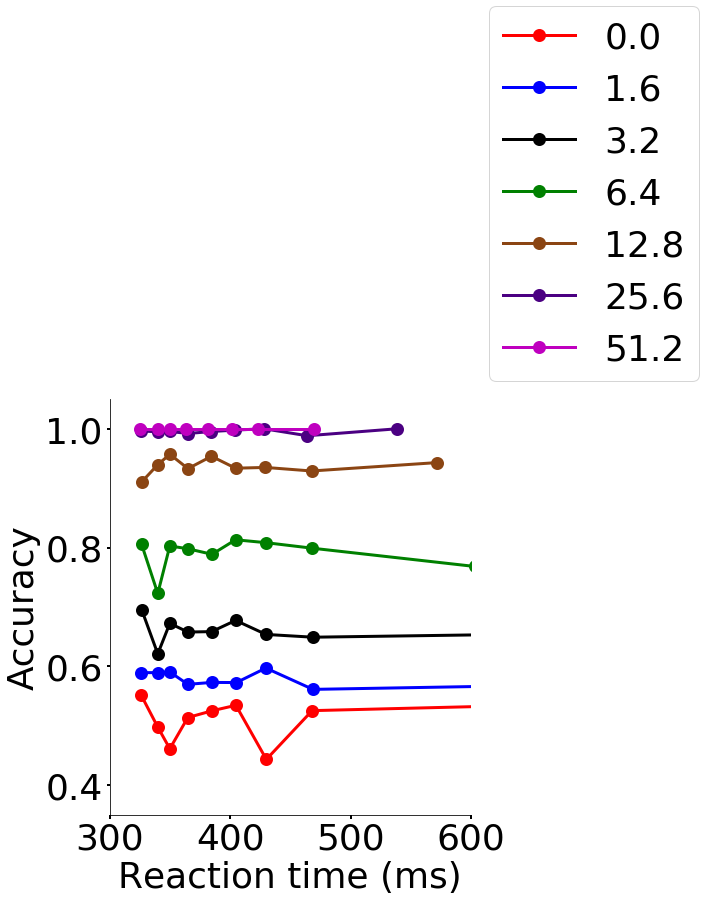

<Figure size 432x288 with 0 Axes>

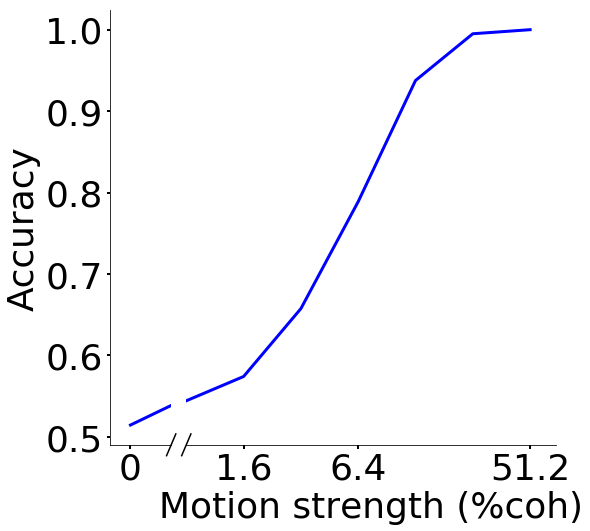

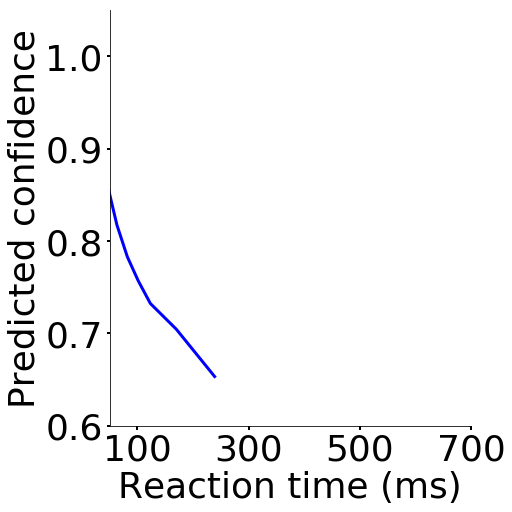

In [21]:
#figure 7B
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(confidence_results_r[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]
    plt.plot(dur + 300, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Predicted confidence")
plt.xlabel("Reaction time (ms)")
plt.ylim([.35,1.05])
plt.xlim([100,1500])
plt.tight_layout()
plt.title("")
plt.savefig('paper_figures/confidence_reaction.png' , format='png', dpi=100)

plt.figure()
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(acc_results_r[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]
    plt.plot(dur + 300, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Accuracy")
plt.xlim([300, 600])
plt.ylim([.35,1.05])
plt.xlabel("Reaction time (ms)")
plt.tight_layout()
plt.title("")
plt.legend(np.array(cohs)/10, bbox_to_anchor =(1, 1))

plt.savefig('paper_figures/accuracy_reaction.png' , format='png', dpi=100)


plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results_r, ax, ax2, _fmt = '-', _color = 'blue', error = False)
#analysisCoherence(acc_results_r, ax, ax2, _fmt = 'o', _color = 'blue', error = True)


#plt.ylim([0.6, 1.05])
#plt.tight_layout()
ax.set_ylabel("Accuracy")


plt.figure()
setPlot()
analysisTime(confidence_results_r, _fmt = '-', _color = 'blue', error = False)
#analysisTime(confidence_results_r, _fmt = 'o', _color = 'blue', error = True)

plt.ylabel("Predicted confidence")
plt.ylim([0.6, 1.05])
#plt.xlim([100,1500])
plt.xlabel("Reaction time (ms)")
plt.tight_layout()
plt.title("")
plt.savefig('paper_figures/confidence_reaction_time.png' , format='png', dpi=100)
plt.show()


/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Reaction Time')

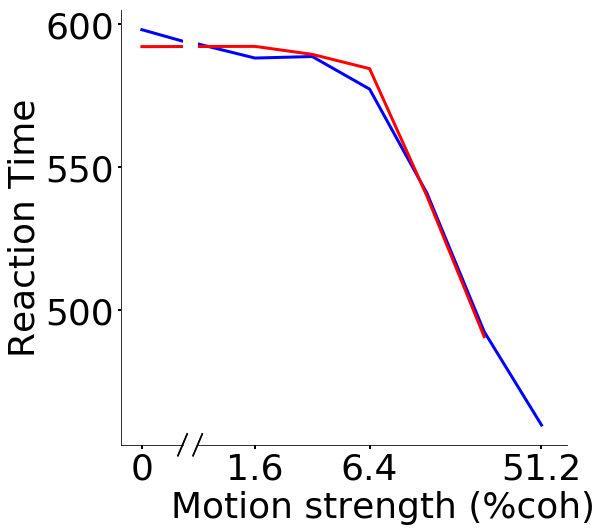

In [22]:
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisDurCoherence(confidence_results_r_correct, ax, ax2, add_time = sac_time,  _fmt = '-', _color = 'blue')
analysisDurCoherence(confidence_results_r_error, ax, ax2, add_time = sac_time,  _fmt = '-', _color = 'red')
#analysisDurCoherence(confidence_results_r_error, ax, ax2, add_time = sac_time,  _fmt = 'o', _color = "red", error = True)

#analysisDurCoherence(confidence_results_r, ax, ax2, add_time = 300,  _fmt = '-', _color = 'green')
ax.set_ylabel("Reaction Time")


/home/koosha/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


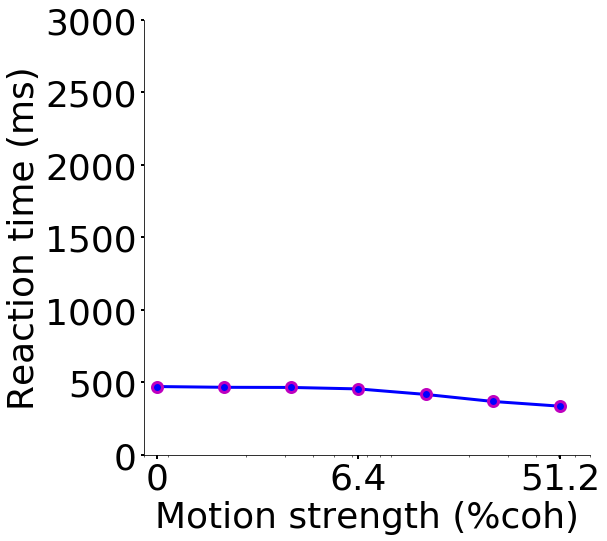

In [23]:
avg_dur = {}
a = []
num = {}
for i in range(len(cohs)):
    c = cohs[i]
    avg_dur[c] = 0
    num[c] = 0
    for point in confidence_results_r[c]:
        avg_dur[c] += (point.avg_duration * point.nrData)
        num[c] += point.nrData
    avg_dur[c] /= num[c]
    a.append(avg_dur[c]+300)

ca = (np.array(cohs))
ca[0] = 8
setPlot()
plt.plot(ca, a, '-o', color = 'blue', alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   
plt.gca().set_xscale('log')
plt.gca().set_xticks([8, 64, 512])
plt.gca().set_xticklabels([0, 6.4, 51.2])
plt.xlim([7, 700])
plt.xlabel("Motion strength (%coh)")
plt.ylabel("Reaction time (ms)")
    
plt.ylim([0, 3000])
plt.title("")
plt.show()




In [24]:
num_samples = 20000
cost =  2 * 10 ** -3
gamma = 1.
k = 1
std_i = 5
std_z  = .75
step_time = 10
sz = .4

Sequential report

In [ ]:
rcpc_s = POMDPReactionSeqSz(k, mu_i, sz, std_i, cohs, cost, 20000, 250, std_z, step_time, num_samples)
fake_trials = rcpc_s.generateTrials()
time_windows_f = Trial.sortAndDivideToQuantiles(fake_trials, num_quantiles) 
trials_sep_sure_f = Trial.seperateBySureShown(fake_trials)
trials_acc_f = Trial.seperateByCoherence(trials_sep_sure_f[False])
analysis = Analysis(time_windows_f)
acc_results_rs = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'Accuracy')
confidence_results_rs = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'Confidence')
confidence_results_rs_correct = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'ConfidenceCorrect')
confidence_results_rs_error = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'ConfidenceIncorrect')

In [ ]:
#figure 7d
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(confidence_results_rs[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]  
    plt.plot(dur + 250, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Predicted confidence")
plt.ylim([.5,1.05])
plt.xlim([100,2000])
plt.xlabel("Reaction time (ms)")
plt.title("")
plt.tight_layout()
plt.savefig('paper_figures/confidence_reaction_seq.png' , format='png', dpi=1000)
        

In [ ]:
cohs

In [ ]:
#confidence_results_rs_error.pop(0)
confidence_results_rs_error.pop(512)
#confidence_results_rs_error.pop(256)


f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results_rs_correct, ax, ax2, _fmt = '-', _color = 'green', error = False)
#analysisCoherence(confidence_results_rs_correct, ax, ax2, _fmt = 'o', _color = 'blue', error = True)
analysisCoherence(confidence_results_rs_error, ax, ax2, _fmt = '--', _color = 'red', error = False)
#analysisCoherence(confidence_results_rs_error, ax, ax2, _fmt = 'o', _color = 'red', error = True)

ax.set_ylabel("Predicted confidence")

#ax.set_ylim([.45,1.05])
#ax.set_yticks([.5, .6, .70, .80, .90, 1])

custom_lines = [matplotlib.lines.Line2D([0], [0], color='green', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3, ls = '--')]
#plt.legend(custom_lines, ['Correct', 'Incorrect'],loc = 2, bbox_to_anchor=(-.22, 1.05))
plt.savefig('paper_figures/confidence_reaction_seq_correct_error_coh.png' , format='png', dpi=100, bbox_inches= "tight")


# Low high volatility (figure 7e)

In [ ]:
std_i = .329
std_z = 1.00
k = 1.108
threshold = .734 
num_samples = 20000    
std_z = 1
h_std_z = (2.5 **.5) * std_z
cp = ContinuousPOMDP(k, mu_i, std_i, std_z, step_time, num_samples)
acc_results = analysis.generateForMultipleCohs(cp, trials_acc, cohs, 'Accuracy')
confidence_results = analysis.generateForMultipleCohs(cp, trials_acc, cohs, 'Confidence')
env = Environment(cp, k, h_std_z, step_time, num_samples)
accuracy_results_h = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Accuracy')
confidence_results_h = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Confidence')   
acc_pos  = copy.copy(acc_results)
acc_h_pos  = copy.copy(accuracy_results_h)
acc_pos.pop(0)
acc_h_pos.pop(0)
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax, ax2, _fmt = '-', error = False)
analysisCoherence(confidence_results, ax, ax2, _fmt = 'o')
analysisCoherence(confidence_results_h, ax, ax2, _color = 'red', _fmt = '-', error = False)
analysisCoherence(confidence_results_h, ax, ax2, _color = 'red', _fmt = 'o')
ax.set_ylabel("Predicted confidence")
custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3)]
plt.legend(custom_lines, ['Low volatility', 'High volatility'],loc = 4, fontsize = 32, labelspacing= 0,  borderpad = 0.1)

ax.set_ylim([.5,1.05])
plt.savefig('paper_figures/confidence_low_high.png' , format='png', dpi=100, bbox_inches = "tight")

plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax,ax2, _fmt = '-', error = False)
analysisCoherence(acc_pos, ax, ax2, _fmt = 'o')
analysisCoherence(accuracy_results_h, ax, ax2,  _color = 'red', _fmt = '-', error = False)
analysisCoherence(acc_h_pos, ax, ax2, _color = 'red', _fmt = 'o')
ax.set_ylabel("Accuracy")

ax.set_ylim([.5,1.05])
plt.savefig('paper_figures/acc_low_high.png' , format='png', dpi=100, bbox_inches = "tight")


In [ ]:
std_z = 1
h_std_z = (2.5 **.5) * std_z
cp = ContinuousPOMDP(k, mu_i, std_i, std_z, step_time, num_samples)
acc_results = analysis.generateForMultipleCohs(cp, trials_acc, cohs, 'Accuracy')
confidence_results = analysis.generateForMultipleCohs(cp, trials_acc, cohs, 'Confidence')
env = Environment(cp, k, h_std_z, step_time, num_samples)
accuracy_results_h = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Accuracy')
confidence_results_h = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Confidence')    

In [ ]:
acc_pos  = copy.copy(acc_results)
acc_h_pos  = copy.copy(accuracy_results_h)
acc_pos.pop(0)
acc_h_pos.pop(0)


In [ ]:
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax, ax2, _fmt = '-', error = False)
analysisCoherence(confidence_results, ax, ax2, _fmt = 'o')
analysisCoherence(confidence_results_h, ax, ax2, _color = 'red', _fmt = '-', error = False)
analysisCoherence(confidence_results_h, ax, ax2, _color = 'red', _fmt = 'o')
ax.set_ylabel("Predicted confidence")
custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3)]
plt.legend(custom_lines, ['Low volatility', 'High volatility'],loc = 4, fontsize = 32, labelspacing= 0,  borderpad = 0.1)

ax.set_ylim([.5,1.05])
plt.savefig('paper_figures/confidence_low_high.png' , format='png', dpi=100, bbox_inches = "tight")

plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax,ax2, _fmt = '-', error = False)
analysisCoherence(acc_pos, ax, ax2, _fmt = 'o')
analysisCoherence(accuracy_results_h, ax, ax2,  _color = 'red', _fmt = '-', error = False)
analysisCoherence(acc_h_pos, ax, ax2, _color = 'red', _fmt = 'o')
ax.set_ylabel("Accuracy")

ax.set_ylim([.5,1.05])
plt.savefig('paper_figures/acc_low_high.png' , format='png', dpi=100, bbox_inches = "tight")


# Cost and meta-d'

In [ ]:
num_samples = 50000
cost = 10 **-8
cpc = POMDPWithCost(k, 0.0, std_i, cohs, cost, 1000, std_z, 10.0, num_samples)

In [ ]:
cp = ContinuousPOMDP(k, mu_i, std_i, std_z, step_time, num_samples)
wage_results = analysis.generateForMultipleCohs(cp, trials_sure, cohs, 'Wage', threshold)
confidence_results = analysis.generateForMultipleCohs(cp, trials_acc, cohs, 'Confidence')
acc_results = analysis.generateForMultipleCohs(cp, trials_acc, cohs, 'Accuracy')


In [ ]:
wage_results_c = analysis.generateForMultipleCohs(cpc, trials_sure, cohs, 'Wage', threshold)
confidence_results_c = analysis.generateForMultipleCohs(cpc, trials_acc, cohs, 'Confidence')
acc_results_c = analysis.generateForMultipleCohs(cpc, trials_acc, cohs, 'Accuracy')

In [ ]:
acc_pos  = copy.copy(acc_results)
acc_c_pos  = copy.copy(acc_results_c)
acc_pos.pop(0)
acc_c_pos.pop(0)

In [ ]:
num_samples = 5000
cost = 10 ** -4
cpch = POMDPWithCost(k, 0.0, std_i, cohs, cost, 1000, std_z, 10.0, num_samples)

In [ ]:
wage_results_ch = analysis.generateForMultipleCohs(cpch, trials_sure, cohs, 'Wage', threshold)
confidence_results_ch = analysis.generateForMultipleCohs(cpch, trials_acc, cohs, 'Confidence')
acc_results_ch = analysis.generateForMultipleCohs(cpch, trials_acc, cohs, 'Accuracy')
acc_ch_pos  = copy.copy(acc_results_ch)
acc_ch_pos.pop(0)

In [ ]:
monkey = 1

f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax,ax2, _fmt = '-', error = False)
analysisCoherence(acc_pos, ax, ax2, _fmt = 'o')
analysisCoherence(acc_results_c, ax, ax2,  _color = 'red', _fmt = '-', error = False)
analysisCoherence(acc_c_pos, ax, ax2, _color = 'red', _fmt = 'o')
analysisCoherence(acc_ch_pos, ax, ax2, _color = 'green', _fmt = 'o')
analysisCoherence(acc_results_ch, ax, ax2,  _color = 'green', _fmt = '-', error = False)

ax.set_ylabel("Accuracy")

ax.set_ylim([.45,1.05])
plt.savefig('paper_figures/acc_cost.png' , format='png', dpi=100, bbox_inches = "tight")

plt.figure()
analysisTime(acc_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(acc_results, _fmt = 'o', _color = 'blue', error = True)
analysisTime(acc_results_c, _color = 'red', _fmt = '-', error = False)
analysisTime(acc_results_c, _color = 'red', _fmt = 'o')
analysisTime(acc_results_ch, _color = 'green', _fmt = '-', error = False)
analysisTime(acc_results_ch, _color = 'green', _fmt = 'o')
plt.ylabel("Predicted confidence", color = "white")
plt.ylim([0.45, 1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_cost_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')


plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax, ax2, _fmt = 'o')
analysisCoherence(confidence_results, ax, ax2, _fmt = '-', error = False)
analysisCoherence(confidence_results_c, ax, ax2,  _color = 'red', _fmt = '-', error = False)
analysisCoherence(confidence_results_c, ax, ax2, _color = 'red', _fmt = 'o')
analysisCoherence(confidence_results_ch, ax, ax2,  _color = 'green', _fmt = '-', error = False)
analysisCoherence(confidence_results_ch, ax, ax2, _color = 'green', _fmt = 'o')
ax.set_ylabel("Predicted confidence")
ax.set_ylim([.45, 1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_cost_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')


plt.figure()
analysisTime(confidence_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(confidence_results, _fmt = 'o', _color = 'blue', error = True)
analysisTime(confidence_results_c, _color = 'red', _fmt = '-', error = False)
analysisTime(confidence_results_c, _color = 'red', _fmt = 'o')
analysisTime(confidence_results_ch, _color = 'green', _fmt = '-', error = False)
analysisTime(confidence_results_ch, _color = 'green', _fmt = 'o')
plt.ylabel("Predicted confidence", color = "white")
plt.ylim([0.45, 1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_cost_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#fig 4c
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(wage_results, ax, ax2, _fmt = 'o', _color = 'blue', error = True)
analysisCoherence(wage_results_c, ax, ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(wage_results_c, ax, ax2, _fmt = 'o', _color = 'red', error = True)
analysisCoherence(wage_results_ch, ax, ax2, _fmt = '-', _color = 'green', error = False)
analysisCoherence(wage_results_ch, ax, ax2, _fmt = 'o', _color = 'green', error = True)

ax.set_ylim([0.0, 1.2])
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_ylabel("Probability sure")
plt.savefig('paper_figures/wage_cost_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(wage_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(wage_results_c, _fmt = '-', _color = 'red', error = False)
analysisTime(wage_results, _fmt = 'o', _color = 'blue', error = True)
analysisTime(wage_results_c, _fmt = 'o', _color = 'red', error = True)
analysisTime(wage_results_ch, _fmt = '-', _color = 'green', error = False)
analysisTime(wage_results_ch, _fmt = 'o', _color = 'green', error = True)

plt.ylim([0.05, 0.65])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = "white")

custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3),
                matplotlib.lines.Line2D([0], [0], color='sienna', lw=3),
                matplotlib.lines.Line2D([0], [0], color='green', lw=3)     
               ]

if monkey == 2: 
    plt.legend(custom_lines, ['no cost', 'with cost'], loc = 4, fontsize = 28, labelspacing= 0, borderpad = 0.2, )

plt.savefig('paper_figures/wage_cost_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.show()